In this section we will cover data augmentation, a mechanism of generating synthetic data for image data. We will use a pre-trained Xception model that was trained on Imagenet data and fine-tune it to accommodate clothing examples. We will achive this by applying transfer learning technique to fine tune to clothing examples, and then generate synthetic data to enhance its performance. With transfer learning we can freeze the pre-trained layers of the network, and only train the new layers by updating the final output. This helps the model to quickly adapt to the new dataset with less training time.

By applying transfer learning and image augmentation techniques on top of a pre-trained Xception model, we can generate synthetic data that can improve the performance of the model on new data. This approach is widely used in various applications, including image classification, object detection, and segmentation.

To start, we need to load the pre-trained Xception model using the tensorflow library. We can do this by simply importing the Xception model from the tensorflow module and setting the include_top parameter to False to exclude the top layer of the model.

Next, we will add a custom classifier on top of the pre-trained Xception model. We can achieve this by adding a few Dense layers and a final output layer with the number of classes equal to the number of clothing categories we want to classify.

To further improve the model's performance, we will apply image augmentation using the out-of-the-box TensorFlow features. This can include rotation, zooming, flipping, and other techniques to create variations in the training data and make the model more robust.

Finally, we will train the model using the augmented training data and evaluate its performance on the validation set. We can fine-tune the hyperparameters of the model and the augmentation techniques to achieve better accuracy.

Note: This example is adapted from chapter 7 from a book [Machine Learning Bookcamp](https://livebook.manning.com/book/machine-learning-bookcamp/chapter-7/), and is also made available by the author of the book, through a course run by author's company [DataTalks Club](https://github.com/alexeygrigorev/mlbookcamp-code).

To start we will first import all the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

2024-01-29 17:34:32.614910: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Next we will download the data by cloning the dataset from a github repo

In [2]:
!git clone git@github.com:alexeygrigorev/clothing-dataset-small.git

fatal: destination path 'clothing-dataset-small' already exists and is not an empty directory.


Next we will load an image of the pant we have downloaded from the clothing dataset repo.
To load the image we will use the `load_img` function

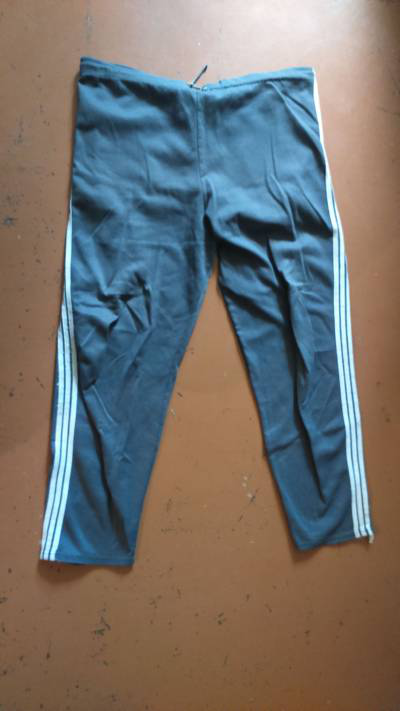

In [3]:
path = './clothing-dataset-small/train/pants/12bfe0f0-accc-4539-ab51-53f63534938e.jpg'
load_img(path)

Next we will represent the image as a numpy array, as this is the format in which the model expects the image. We also need to ensure that all images are passed to the model with same dimensions, hence we will choose a standard of (299, 299, 3), which means 299 pixels top to bottom and 299 pixels left to right, and three colour channels, which are Red , Green and Blue. Each pixel will be represented three times with values from 0-255 for each colour channel.

We will load the above image with target size of (299,299)

In [4]:
img = load_img(path=path, target_size=(299,299))
img_input = np.array(img)

img_input.shape

(299, 299, 3)

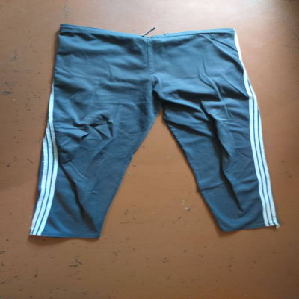

In [5]:
img

Now we have ensured the dimensions, next we will load the pretrained exception model and specify the imput format which is the same as dimensions of the above image. Once we will load the model then we will score the image, and check the prediction.

In [6]:
model = Xception(weights='imagenet', input_shape=(299,299,3))

2024-01-29 17:34:44.010399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-29 17:34:44.020609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-29 17:34:44.023860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-29 17:34:44.027270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

The model expects the list of images and in a particular format, hence we will pass the previous image as a list, and convert into a numpy array. Then we will preprocess the image using `preprocess_input` and use then score the input. The prediction will be stored in prediction.

The `preprocess_input` function is required to preprocess the image data required by the model, as when the Exception model was trained, the input values were transformed from 0-255 and scaled to have values between -1 and 1. This is important, because distribution of colour scales may affect prediction. Imagine if red colour scales were between 0-100, while blue colour scales were between 200-300, this may have led to instable model. Hence, scaling was important. Without the correct prerprocessing, predictions won't make sense. 

In [7]:
img_preprocessed = preprocess_input(np.array([img_input]))
pred = model.predict(img_preprocessed)
pred.shape

2024-01-29 17:34:59.417866: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-01-29 17:35:00.110218: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-29 17:35:00.110853: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-29 17:35:00.110876: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-29 17:35:00.111526: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-29 17:35:00.111585: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


(1, 1000)

Next we will decode these predictions with a convenience function. The model will provide probability of top 5 labels out of 1000 different classes, as the Xception model was trained to predict 1000 labels. We don't believe the target labels have clothing example, hence after the next steps we will move to transfer learning. To decode the predictions we will use the `decode_predictions` function. The `decode_predictions` is a convenience function to provide predictions in a format that can be easily understood.

In [8]:
decode_predictions(pred)

[[('n03594734', 'jean', 0.651147),
  ('n04371430', 'swimming_trunks', 0.22369406),
  ('n03710637', 'maillot', 0.004711655),
  ('n04525038', 'velvet', 0.0038891942),
  ('n03595614', 'jersey', 0.003085624)]]

Its quite clear that pants image is closest to the jean label and then swimming trunks as per the labels used in the Exception model, but in the training data, there is no jean or swimming trunks label. Next we will extract the training data and make sure its preprocessed before we pass it for training.

We will use transfer learning in the next step, for which we will leverage entire training data. We will use the `ImageDataGenerator` to help process the input data that the model requires and then create training and validation datasets. The training data will have 3041 images while validation data will have 341 images. For preproessing we will use 150 by 150 pixels instead of 299 by 299 pixels, to reduce training time. 

In [9]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

Next we will use the `flow_from_directory` propoperty to process the entire training and validation dataset. We will use the seed 42 to ensure data is  passed to the network, its passed with same randomisation, and result at each training layer is reproducible.
For the validation data will utilise `shuffle=False` to ensure at validation layer there is no randomisation at each training step, but data is passed sequentially.

In [10]:
train_ds = train_gen.flow_from_directory(directory='./clothing-dataset-small/train/', target_size=(150,150), batch_size=32, seed=42)
validation_ds = train_gen.flow_from_directory(directory="./clothing-dataset-small/validation/", target_size=(150,150), batch_size=32, shuffle=False)

Found 3081 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


We will now view the target classes of our dataset

In [11]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

Next we will proceed to apply transfer learning. To do so we must first extract the base layer or in other words extract the convulational layer of the Exception model and ensure its frozen. This will ensure we get access to the feature map of the image data of 1 million+ images. To do so we will use the parameter `include_top=False`, which will ignore the dense layers, and will return the botton layer of convulational neural network. Next we will build a custom dense layer with the 10 class labels highlighted above and train the dense layer for our usecase. 

In [12]:
base_cnn_model = Xception(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_cnn_model.trainable = False

Next we will build the architecture of the dense layer and combine with the base layer.
We will first define the input standard such that the base model can provide the vector suitable for input of the same standard. We will use (150,150,3) so that model can be trained faster as more pixels can slow down training. Next we will transform the vector from base layer to two dimensional array, for that we will use a method called pooling which can help reduce the spatial size of feature maps but still retain the key information about the base layer. Next we will create a dense layer where we specify the nunber of outputs which are 10, and apply softmax activation to return a probability.

We will then define the loss function and utilise Adam optimizer with learning rate of 0.005, and will choose accuracy as a metric.

In [13]:
inputs = keras.Input(shape=(150,150,3))
base = base_cnn_model(inputs)
vectors = keras.layers.GlobalAveragePooling2D()(base)
inner = keras.layers.Dense(100, activation='relu')(vectors)
drop = keras.layers.Dropout(rate=0.2)(inner)
outputs = keras.layers.Dense(10, activation='softmax')(drop)
model = keras.Model(inputs, outputs)

learning_rate = 0.005
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()

Next we will compile the model with the optimised and loss to achieve the best accuracy

In [14]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

Next we will train the network with the clothing dataset

In [15]:
model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
97/97 [==============================] - 18s 156ms/step - loss: 1.1373 - accuracy: 0.6228 - val_loss: 0.7507 - val_accuracy: 0.7830
Epoch 2/10
97/97 [==============================] - 12s 118ms/step - loss: 0.6762 - accuracy: 0.7559 - val_loss: 0.6444 - val_accuracy: 0.7742
Epoch 3/10
97/97 [==============================] - 11s 118ms/step - loss: 0.5700 - accuracy: 0.7900 - val_loss: 0.6384 - val_accuracy: 0.7830
Epoch 4/10
97/97 [==============================] - 11s 118ms/step - loss: 0.4679 - accuracy: 0.8351 - val_loss: 0.6386 - val_accuracy: 0.7830
Epoch 5/10
97/97 [==============================] - 11s 117ms/step - loss: 0.3862 - accuracy: 0.8533 - val_loss: 0.6670 - val_accuracy: 0.7801
Epoch 6/10
97/97 [==============================] - 11s 117ms/step - loss: 0.3442 - accuracy: 0.8786 - val_loss: 0.6270 - val_accuracy: 0.7801
Epoch 7/10
97/97 [==============================] - 11s 118ms/step - loss: 0.3154 - accuracy: 0.8796 - val_loss: 0.6345 - val_accuracy: 0.8065

Looking at these results it is clear that the model is overfitted since model achieved 92.7% accuracy on training data and only 81.52% accuray on validation data, which is almost a 11-11% difference at the end of 10 epochs. We could try training dense layer with different learning rates to obtain a more generalised model. A learning rate controls how quick we want the model to learn from training data, and adjust its weights to fit the data. A low learning rate is like watching a video at a slow pace in order to ensure most details are covered, whereas a high learning rate is like watching a video at faster pace and some details may be missed. For the current architecture we want to ensure an optimised learning rate, which is crucial for successful training. It often requires experimentation and tuning to find the optimal balance between convergence speed and accuracy. Another way to reduce over fitting is by adjusting the dropout rate, which is regularisation technique in which at random a percentage of data is ommited, and to tune this parameter experimentation is required as well.  However, these approaches are more model-centric approaches.

For a data-centric approach we may require more data examples or better data examples. We need examples where model does not try to memorise specific pixels, such that if it sees 120 Red in 130 pixel location, it starts believing image is a pant. Hence to ensure a much generalised model we could leverage data augmentation. 

In relation to data-centric AI data augmentation can be referred as a technique to artificially increase the size and diversity of a training dataset by applying various transformations to the existing data. These transformations can include rotation, scaling, cropping, flipping, adding noise, and many others, depending on the type of data being augmented.

There are some common augmentation techniques such as creating different angles of the image, or shifting images, zooming images in and out , flipping them upside down, etc. However, before applying augmenting techniques we must first consider different ways data will be generated. For instance if users will not generate pictures upside down, then augmenting images to create flipped images may only add noise and not provide a good signal to the model. For below example we will apply zoom augmentation where images will be zoomed in and out a little, some shifting where clothing in the images will shift close to the edges, apply vertical flips so if some images are taken using a mirror, we can capture additional data for each scenario. We will achieve this by updating the Image generator function and adding these extra parameters, and then training the model on the best parameters

We will apply rotation range of 10, shear range of 10, width and height shift range of 0.2, zoom range of 0.1 and vertical flip. To achive this we will tweak the `ImageDataGenerator` function, as this will under the hood create more examples of the training data.

We will also create a function that will take in the learning rate and return the model and its parameters.

In [16]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=10,
                               shear_range=10,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.1,
                               vertical_flip=True)

train_ds = train_gen.flow_from_directory(directory='./clothing-dataset-small/train/', target_size=(150,150), batch_size=32, seed=42)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_ds = val_gen.flow_from_directory(directory="./clothing-dataset-small/validation/", target_size=(150,150), batch_size=32, shuffle=False)

Found 3081 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [17]:
def make_fashion_classification_model(learning_rate: float=0.1):
    """Function to create a dense custom model"""
    
    #### Base model ####
    inputs = keras.Input(shape=(150,150,3))
    base = base_cnn_model(inputs)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    #### Dense model #### 
    outputs = keras.layers.Dense(10, activation='softmax')(vectors)
    model = keras.Model(inputs, outputs)
    
    #### Optimizing the model ####
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
    return model

Next we will use the function and pass `0.005` as learning rate and add 50 epochs, since we have generated a lot more data for augmentation

In [23]:
model = make_fashion_classification_model(learning_rate=0.005)
model_run = model.fit(train_ds, validation_data=validation_ds, epochs=50)

Epoch 1/50
97/97 [==============================] - 28s 266ms/step - loss: 1.5281 - accuracy: 0.4920 - val_loss: 0.9664 - val_accuracy: 0.6686
Epoch 2/50
97/97 [==============================] - 25s 255ms/step - loss: 1.2095 - accuracy: 0.5826 - val_loss: 0.8291 - val_accuracy: 0.7331
Epoch 3/50
97/97 [==============================] - 25s 254ms/step - loss: 1.1034 - accuracy: 0.6235 - val_loss: 0.8117 - val_accuracy: 0.7185
Epoch 4/50
97/97 [==============================] - 25s 254ms/step - loss: 1.0346 - accuracy: 0.6495 - val_loss: 0.7599 - val_accuracy: 0.7654
Epoch 5/50
97/97 [==============================] - 25s 254ms/step - loss: 1.0253 - accuracy: 0.6430 - val_loss: 0.6953 - val_accuracy: 0.7830
Epoch 6/50
97/97 [==============================] - 25s 255ms/step - loss: 1.0187 - accuracy: 0.6550 - val_loss: 0.7756 - val_accuracy: 0.7830
Epoch 7/50
97/97 [==============================] - 25s 255ms/step - loss: 0.9961 - accuracy: 0.6553 - val_loss: 0.6974 - val_accuracy: 0.7889

Model achieved lower training accuracy but model is more generalisable and not overfitted. It was also noted that best validation accuracy was achieved at 32nd epoch. However, it is difficult to note at which epoch a model will achieve best accuracy. 

To achieve this we can further utilse a model checkpoint functionality, to ensure only a model that achieves minimum validation accuracy of 78% at a given epoch will be created and saved, and only when a previous best accuracy is surpassed, a new model is created. We can then use these saved models to score test data.

In the next step we will add 0.2 drop out rate and an inner layer of 50. We will update the function for training the network and add the checkpoint functionality. Once the checkpoint is created it will be added as a callback to the fit function.

We encourage practioners to utilise hyperparameterisation with learning rate, dropout rate, and inner layer, with checkpoint to ensure best accuracy.

First we will define the function that takes three inputs learning rate, inner layer and dropout rate.

In [17]:
def make_fashion_classification_model(learning_rate: float=0.001, inner_layer: int=50, drop_rate: float=0.2):
    """Function to create a dense custom model with learning rate, inner layer and dropout rate"""
    
    #### Base model ####
    inputs = keras.Input(shape=(150,150,3))
    base = base_cnn_model(inputs)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    #### Dense model layers #### 
    inner = keras.layers.Dense(inner_layer, activation='relu')(vectors)
    drop = keras.layers.Dropout(rate=drop_rate)(inner)
    outputs = keras.layers.Dense(10, activation='softmax')(drop)
    model = keras.Model(inputs, outputs)
    
    #### Optimizing the model ####
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
    return model

Next we will define the checkpoint where we will save all models with various epochs where validation accuracy is reached to minimum 78%.
We will then add this checkpoint to the callback of the fitting function.

In [18]:
checkpoint_model = keras.callbacks.ModelCheckpoint(filepath="xception_v1_{epoch:02d}_{val_accuracy:.4f}.h5",
                                             monitor="val_accuracy",
                                             save_best_only=True,
                                             initial_value_threshold=0.8,
                                             mode="max")

model = make_fashion_classification_model()
model.fit(train_ds, validation_data=validation_ds, epochs=50, callbacks=[checkpoint_model])

Epoch 1/50
97/97 [==============================] - 28s 266ms/step - loss: 1.4822 - accuracy: 0.5138 - val_loss: 0.8920 - val_accuracy: 0.7155
Epoch 2/50
97/97 [==============================] - 25s 255ms/step - loss: 1.1666 - accuracy: 0.6079 - val_loss: 0.7728 - val_accuracy: 0.7273
Epoch 3/50
97/97 [==============================] - 25s 255ms/step - loss: 1.0078 - accuracy: 0.6611 - val_loss: 0.6955 - val_accuracy: 0.7537
Epoch 4/50
97/97 [==============================] - 25s 256ms/step - loss: 0.9629 - accuracy: 0.6728 - val_loss: 0.6641 - val_accuracy: 0.7830
Epoch 5/50
97/97 [==============================] - 25s 257ms/step - loss: 0.9213 - accuracy: 0.6813 - val_loss: 0.6844 - val_accuracy: 0.7654
Epoch 6/50
97/97 [==============================] - 25s 255ms/step - loss: 0.8759 - accuracy: 0.6998 - val_loss: 0.6676 - val_accuracy: 0.7654
Epoch 7/50
97/97 [==============================] - 25s 256ms/step - loss: 0.8377 - accuracy: 0.7128 - val_loss: 0.6440 - val_accuracy: 0.7947

Now that best model is trained and saved, we will import the saved model and score all the data, and calculate test accuracy.

In [20]:
model = keras.models.load_model('xception_v1_37_0.8123.h5')
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_ds = test_gen.flow_from_directory(directory="./clothing-dataset-small/test/", target_size=(150,150), batch_size=32, shuffle=False, seed=42)

accuracy = model.evaluate(test_ds)[1]
print(f"accuracy on train data was 79.16, where as validation accuracy was 81.23, but test accuracy is {accuracy*100:.2f}")

Found 372 images belonging to 10 classes.
12/12 [==============================] - 2s 94ms/step - loss: 0.6317 - accuracy: 0.7715
accuracy on train data was 79.16, where as validation accuracy was 81.23, but test accuracy is 77.15


The model used to make prediction on the test data, had a training accuracy of 79.16, validation and validation accuracy of 81.23. The test accurcy achieved is just 77.15, which can be iteratively improved but beyond the scope of this example, by utilising hypermarameterised tuning on data augmentation parameters and model centric parameters, which is encouraged in real life. However, due to computing and time constraints is outside the scope of this book.

Next we will extract the target labels and build a function to provide a predicted probabilty score along with the relevant classes. First we will load the image and preprocess it, and then we will score it. 

In [24]:
labels = [i for i in train_ds.class_indices.keys()]

def preprocess_image(path: str, target_size: tuple):
    """Function to preprocess image"""
    
    img = load_img(path=path, target_size=target_size)
    img_input = np.array([np.array(img)])
    preprocessed_image = preprocess_input(img_input)
    return preprocessed_image


def decode_predictions(pred):
    """Function to decode prediction"""
    
    result = {c: format(float(p), '.8f') for c, p in zip(labels, pred)}
    final_prediction = sorted(result.items(), key=lambda x:x[1],  reverse=True)[0]
    return final_prediction

Next we will extract a random image of a pant and run it through a model to get the prediction.

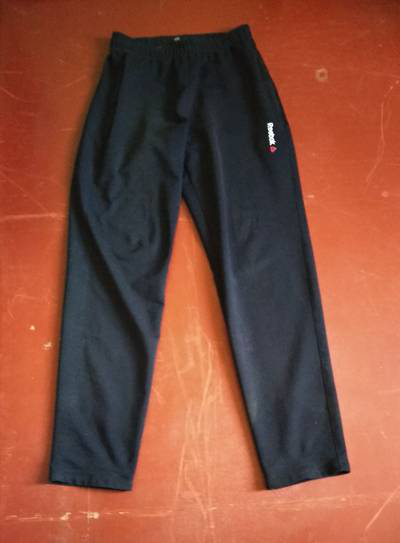

In [22]:
path = './clothing-dataset-small/train/pants/188eaa2d-1a69-49b1-a9fb-7b3789ac93b4.jpg'
load_img(path)

Next we will load the image and preprocess the image before scoring the image. Finally, we will decode the predictions to extract the prediction. For these steps we will leverage the functions created.

In [25]:
preprocessed_image = preprocess_image(path=path, target_size=(150,150))
preds = model.predict(preprocessed_image)
results = decode_predictions(preds[0])
results

1/1 [==============================] - 0s 26ms/step


('pants', '0.99980551')

According to the model, the image has a probability of 99% to be classified as a pant, which is quite accurate.

We have been able to demonstrate, using data centric technique of data augmentation, we were able to generalise the model. We believe by iterating over data parameters of data augmentation we can further improve the model quality. Once the parameters have been tuned, we recommend practionaers to combine model centric techniques of regularisation, learning rate ,inner layers and drop out rate to further tune and improve the model. 